# Lecture 24: Deep Learning

COMP 3921F \
Applied Machine Learning \
Mon 4:40 PM - 5:55 PM \
Tue: 5:00 PM - 6:15 PM

Professor: __Ramesh Natarajan__ \
Email: **ramesh.natarajan@yu.edu** \
Department of Computer Science \
Stern College and Yeshiva University

Date: Feb xx, 2024



## Acknowledgements

1. The starting point for developing the notebook-based instruction material was the set of notebooks provided by the previous  course instructor__[Prof. Zach Glassman](https://www.linkedin.com/in/zachary-glassman-7088844b/)__.
2. These notebooks have been augmented by similar instruction material taken from many, many other sources, including official documentation from many ML libraries and frameworks. I have adapted and modified the content where needed to make it compatible with student level, orientation and proficiency in this course.
3. The primary addition sources include:
   1. Course content from V. Kuleshov, Cornell Tech __[repo](https://github.com/kuleshov/cornell-cs5785-2020-applied-ml/blob/main/notebooks/lecture1-introduction.ipynb)__.
   2. Book and support material from Hal Daume II, __[A course in Machine Learning](http://ciml.info)__. __[repo](https://github.com/hal3/ciml/)__
   3. Book and support material from A. Geron, __[Hands-On Machine Learning with Scikit-Learn, Keras and Tensorflow (3rd edition)](https://homl.info/er3)__. __[repo](https://github.com/ageron/handson-ml3/blob/main/README.md)__




# Announcements

1. Problem Set 2 to be closed this week. Problem Set 3 still open for submission.
2. Recitation will review Deep Learning.
3. You should continue  to review and refresh yourself on the mathematical prerequisites for applied machine learning from part 1 for Deisenroth, Faisal and Ong, __[Mathematics for Machine Learning](https://mml-book.github.io/book/mml-book.pdf)__.



# Deep Learning  


<table>
    <td width="40%"><center>
        <img src="./img/Lecture-24/deep-learning-creative.png" />      
    </center>
    Generated by Chat-GPT 
     </td>  
    <td>
<font size = "+1.2">
Deep learning models are Multilayer Neural Networks which have led to especially significant improvements in image, video, speech and text modeling applications.  These improvements have been achieved through a combination of interesting algorithms (e.g. dropout regularization and stochastic gradient descent), rapid prototyping using several important frameworks that support automatic differentiation (e.g. Pytorch, Tensorflow, Jax),  high-performance hardware implementations on GPUs (for fast convolutions and matrix vector operations).  

</td></table> 


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

# Training Neural Networks

This notebook gives a brief introduction to training Neural Networks and some of the pitfalls and problems you will see along the way.

It strives to give a basic overview of many topics, each one could easily be a lecture on its own.

## Gradient Descent

Lets dive into a bit more detail on the gradient descent algorithm..

In [2]:
import tensorflow as tf
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
_data = tf.keras.datasets.mnist.load_data()
(train_images, train_labels), (test_images, test_labels) = _data
X_train, X_test, y_train, y_test = train_test_split(
    *make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)
)

2024-04-12 23:18:21.132226: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-12 23:18:21.136094: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-12 23:18:21.184462: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 23:18:22.243907: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


An *epoch* is one pass over the training data, and a back-propagation computation to adjust the model weights is carried out for each example in the training data.  

For large datasets, this is too slow and inefficient, and therefore we consider using a batch of input examples for each back propagation step, using a  `batch_size` parameter .  In addition batching the data in this way is also very helpful for optimizing the use of parallel hardware such as GPUs.


In [3]:
import time
class TimingCallback(tf.keras.callbacks.Callback):
    def __init__(self, times, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.times = times
        self._start_time = None
        
    def on_epoch_begin(self, epoch, logs=None):
        self._start_time = time.time()
        
    def on_epoch_end(self, epoch, logs=None):
        self.times.append(time.time() - self._start_time)

In [5]:
from tqdm.keras import TqdmCallback

In [9]:
def train(batch_size, epochs=200):
    print(f'fitting for batch_size: {batch_size}')
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(2,)),
        tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_uniform'),
        tf.keras.layers.Dense(3)
    ])

    model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.005),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    times = []
    history = model.fit(X_train, y_train, 
                        validation_data=(X_test, y_test),
                        epochs=epochs, 
                        batch_size=batch_size, 
                        verbose=0,
                        callbacks=[
                            TimingCallback(times), 
                            TqdmCallback(verbose=1)
                        ],
                        )
    return history, times

In [7]:
#batch_sizes = [1, 50, len(X_train)]
batch_sizes = [16, 32]

In [10]:
# note, this will take several minutes to run....
results = [train(i) for i in batch_sizes]

fitting for batch_size: 16


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

fitting for batch_size: 32


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Text(0.5, 0, 'epoch')

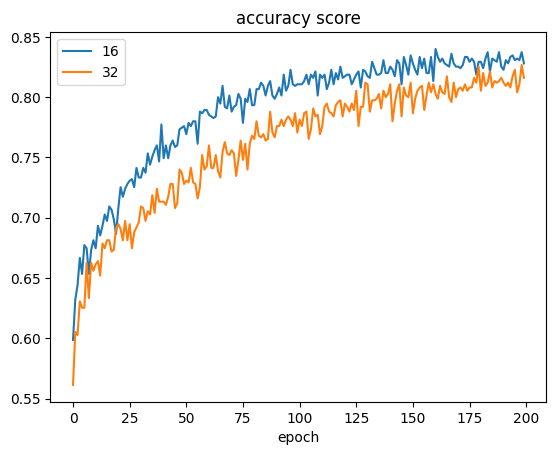

In [11]:
for (history, _), batch_size in zip(results, batch_sizes):
    plt.plot(history.history['accuracy'], label=batch_size)
plt.legend()
plt.title('accuracy score')
plt.xlabel('epoch')

Text(0, 0.5, 'seconds')

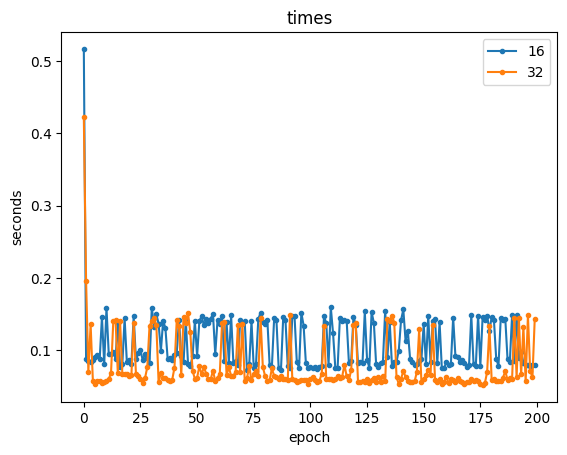

In [12]:
for (_, times), batch_size in zip(results, batch_sizes):
    plt.plot(times, '.-', label=batch_size)
plt.legend()
plt.title('times')
plt.xlabel('epoch')
plt.ylabel('seconds')

Lets talk about the three cases

- `batch_size=1` : Stochastic gradient descent
- `batch_size=N`: batch gradient descent
- `bach_size> 1 AND < N`: minibatch 

### Stochastic gradient Descent

- In this case we are doing a complete forward and back propagation through the network on each step
- This is very slow
- Introduces lots of randomness into the network (which is not entirely bad).
- Only requires one sample at a time, so it can scale very well to big datasets

### Batch Gradient Descent

- In this case we look at all samples in the training set and move due to their average gradient.
- This can be faster as we need less steps in our optimization
- Can be get caught in local minima easily
- Requires all samples

### Minibatch Gradient Descent

- Combination of previous two
- Batch size is not 1, but more like 32
- Has advantages of being faster with fewer updates
- Has enough randomness to not be as prone to local minima
- Only requires a few samples, so can typically scale well

## Data Preprocessing

Algorithms can also be sensitive to feature generation (its not just "throw it in the network and go".  For example, lets look at if we can do better in our model by rescaling the pixel values.

We will work with the fashion MNIST data from last lecture.

In [33]:
_data = tf.keras.datasets.fashion_mnist.load_data()
(train_images, train_labels), (test_images, test_labels) = _data

def compile_and_fit(model):
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    model.fit(train_images, train_labels, 
                    validation_data=(test_images, test_labels),
                    epochs=10,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)]
        )
    return model

Lets start with a simple model using no rescaling.  We will be able to get about 80% validation error (note for a better test we could also use a hold out set.)

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(140, activation='relu'),
    tf.keras.layers.Dense(10)
])

compile_and_fit(model)

Epoch 1/10


/opt/tljh/user/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6699 - loss: 9.2308 - val_accuracy: 0.7167 - val_loss: 0.8165
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7265 - loss: 0.7519 - val_accuracy: 0.7347 - val_loss: 0.6958
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7425 - loss: 0.6558 - val_accuracy: 0.7318 - val_loss: 0.7282
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7738 - loss: 0.6030 - val_accuracy: 0.7366 - val_loss: 0.6947
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8000 - loss: 0.5638 - val_accuracy: 0.7840 - val_loss: 0.6656
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8199 - loss: 0.5170 - val_accuracy: 0.8050 - val_loss: 0.5622
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8208 - loss: 0.5080 - val_accuracy: 0.7958 - val_loss: 0.5736
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8235 - loss: 0.5142 - val_accurac

<Sequential name=sequential_3, built=True>

Now we can add a `Rescaling` layer which will normalize all the inputs between 0 and 1 by dividing by the maximum value (255).

In [15]:
train_images.max(), train_images.min()

(255, 0)

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Dense(140, activation='relu'),
    tf.keras.layers.Dense(10)
])

compile_and_fit(model)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7860 - loss: 0.6183 - val_accuracy: 0.8363 - val_loss: 0.4611
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8643 - loss: 0.3776 - val_accuracy: 0.8430 - val_loss: 0.4318
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8765 - loss: 0.3390 - val_accuracy: 0.8600 - val_loss: 0.3721
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8883 - loss: 0.3052 - val_accuracy: 0.8699 - val_loss: 0.3550
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8907 - loss: 0.2950 - val_accuracy: 0.8782 - val_loss: 0.3528
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8971 - loss: 0.2735 - val_accuracy: 0.8480 - val_loss: 0.4122
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9012 - loss: 0.2654 - val_accuracy: 0.8763 - val_loss: 0.3424
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9043 - loss: 0.2573 - 

<Sequential name=sequential_4, built=True>

## Data Augmentation and Jittering

We can see we do much better.  We can also introduce other augmentation techniques like shifting the data, rotating the data.  Here we will randomly rotate the image by a little bit.  

*Note:* These layers will be active only during training, but not during prediction.

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(140, activation='relu'),
    tf.keras.layers.Dense(10)
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

history = model.fit(train_images, train_labels, 
                    validation_data=(test_images, test_labels),
                    epochs=10,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)]
                    )

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 1.2048 - accuracy: 0.5634 - val_loss: 0.7110 - val_accuracy: 0.7567
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 1.0487 - accuracy: 0.6150 - val_loss: 0.6941 - val_accuracy: 0.7486
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.9896 - accuracy: 0.6366 - val_loss: 0.6442 - val_accuracy: 0.7649
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.9624 - accuracy: 0.6473 - val_loss: 0.6053 - val_accuracy: 0.7869
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.9229 - accuracy: 0.6600 - val_loss: 0.5800 - val_accuracy: 0.7916
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.9136 - accuracy: 0.6639 - val_loss: 0.6023 - val_accuracy: 0.7838
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.8946 - accuracy: 0.6697 - val_loss: 0.5867 - val_accuracy:

The augmentation is useful because it helps our model generalize to more possibilities.  It can even make the network resilient to things like rotation which often crop up in real world problems.

# Vanishing gradients

We know that the training requires understanding the computation of the  gradient using back propagation (via the chain rule of differentiation), which requires taking the product of the derivatives of the activation function that is used in each hidden layer. 

As can be seen from the figure below for the case where the activation function is the hyperbolic tangent, the derivative of this function is zero except for small region of activation (between $\pm 2$).

This is known as the **vanishing gradient problem** since the network weights will not be updated in this case.  

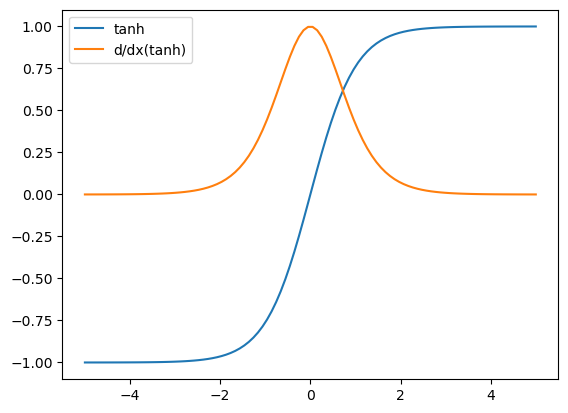

In [15]:
import numpy as np
x = np.linspace(-5, 5, 100)
plt.plot(x, np.tanh(x), label='tanh')
plt.plot(x, 1/(np.cosh(x)**2), label='d/dx(tanh)')
plt.legend()\
plot.show()

### Activation Functions

In order to avoid the vanishing gradients problem, the activation function have been proposed


- ReLU Rectified Linear Unit
- Leaky ReLU
- Exponential Linear Unit
- Scaled Exponential Linear Unit

The ReLU is a very common choice since it avoids the vanishing gradients problems, since the gradient (at least for positive inputs) is always 1. 

While it helps induce sparsity in the network due to its one-sidedness, in some cases this can also lead to segments of the neural network having vanishing gradient.  An alternative in this case is the  Leaky RelU

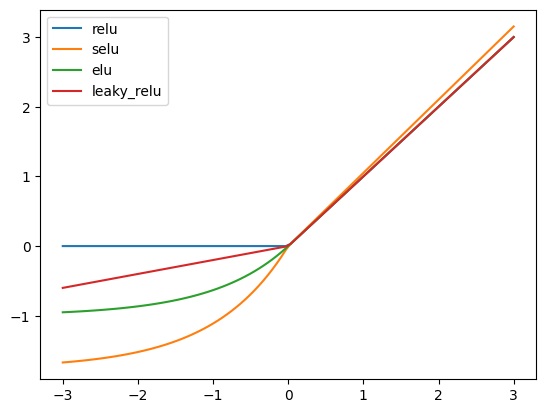

In [13]:

from tensorflow.keras import activations

x = np.linspace(-3, 3, 100)

for func in ['relu',  'selu', 'elu', 'leaky_relu']:
    plt.plot(x, getattr(tf.keras.activations, func)(x), label=func)
plt.legend()
plt.show()

## Exploding gradients

Exploding gradient problem - While we have solved the vanishing gradient problem, sometimes large unbounded gradients can cause the gradient to get too large and blow up.  Often can be solved by proper initialization.

Takeaways - Lots of intricacies to training, need to keep track of proper initialization, activation functions etc.

# Optimizers

Many optimizers have been developed for Neural Networks that address some of the issues with the use of gradient descent.

For example, in SGD we have a `step_size` hyperparameter which controls the learning rate.  However this quantity can be hard to set without some experimentation - too large and it is hard to converge, too small and it converges but very slowly.


Lets look at a simple case with a few different learning rates.

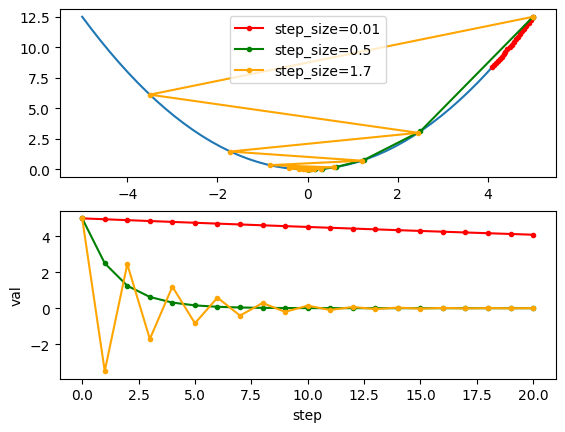

In [18]:
def loss(x):
    return .5 * x ** 2
def optimize(start_value, step_size, steps=20):
    vals = [start_value]
    for step in range(steps):
        val = vals[-1]
        vals.append(val - step_size * val)
    return np.array(vals)

fig, ax = plt.subplots(2, 1)
x = np.linspace(-5, 5)
ax[0].plot(x, loss(x))
colors = ['r', 'g', 'orange']
for step_size, c in zip([.01, .5, 1.7], colors):
    opt = optimize(5, step_size)
    ax[0].plot(opt, loss(opt), '.-', label=f'step_size={step_size}', c=c)
    ax[1].plot(opt, '.-', c=c)
ax[0].legend()
ax[1].set_xlabel('step')
ax[1].set_ylabel('val')
plt.show()

In order to improve this, there are a number of methods which help by various methods such as 

momentum - (automatic) modify  gradients based on the values of previous gradients
adaptive learning rates - (user specified) manually control learning rates based on so-called learning rate curves

We can see how some of these work in practice by using some of the Tensorflow optimizers

Text(0, 0.5, 'var')

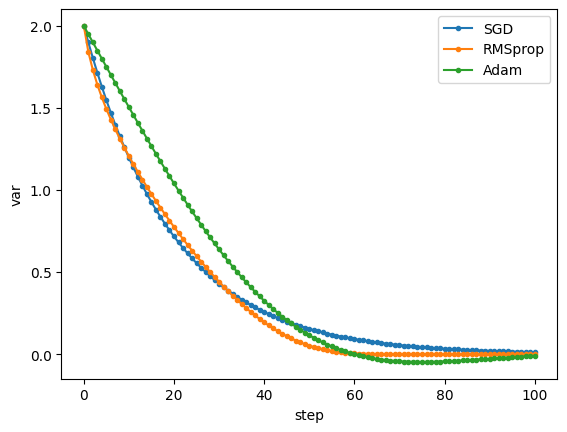

In [30]:
def run(optimizer, start_value, steps=100):
    var = tf.Variable(start_value)
    loss = lambda: .5 * var**2
        
    vals = [start_value]
    for step in range(steps):
        with tf.GradientTape() as g:
            g.watch(var)
            t = loss()
            gradients = g.gradient(t, [var])
        optimizer.apply_gradients(zip(gradients, [var]))
        vals.append(var.numpy())
    return vals
  # Calculate the gradients

LR = .05
for opt in [
    tf.keras.optimizers.SGD(learning_rate=LR),
    tf.keras.optimizers.RMSprop(learning_rate=LR),
    tf.keras.optimizers.Adam(learning_rate=LR)
]:
    vals = run(opt, 2.0)
    plt.plot(vals, '.-', label=opt.__class__.__name__)
plt.legend()
plt.xlabel('step')
plt.ylabel('var')
plt.show()

# Dropout

We have many parameters in deep learning models,  If you ever want to check, look at the model summary (need to compile it first)

In [34]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Dense(140, activation='relu'),
    tf.keras.layers.Dense(10)
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 140)            │       109,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,410 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,310 (434.80 KB)

 Trainable params: 111,310 (434.80 KB)

 Non-trainable params: 0 (0.00 B)

Even simple networks will have hundreds of thousands of parameters, so how to avoid overfitting?

The simplest method, and on that is perhaps surprisingly successful is the notion of dropout (although hopefully it won't be so surprising why after this lecture :))

The basic idea in dropout is the following

1. On each sample, randomly drop each weight with probability $p$
2. Rescale all weights to account for dropped weights
3. Proceed as normal

In [35]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(250, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(10)
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
history = model.fit(train_images, train_labels, 
            validation_data=(test_images, test_labels),
            epochs=100,
            callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)]
            )

Epoch 1/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6135 - loss: 9.4254 - val_accuracy: 0.7183 - val_loss: 0.7369
Epoch 2/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6985 - loss: 0.8202 - val_accuracy: 0.7853 - val_loss: 0.6470
Epoch 3/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7280 - loss: 0.7507 - val_accuracy: 0.7977 - val_loss: 0.5948
Epoch 4/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7448 - loss: 0.7222 - val_accuracy: 0.8168 - val_loss: 0.5821
Epoch 5/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7582 - loss: 0.7002 - val_accuracy: 0.7964 - val_loss: 0.5721
Epoch 6/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7631 - loss: 0.6910 - val_accuracy: 0.7986 - val_loss: 0.7636
Epoch 7/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7667 - loss: 0.6806 - val_accuracy: 0.8002 - val_loss: 0.5664
Epoch 8/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7735 - loss:

### Why does this work?

A smaller network is less prone to overfitting

Each individual iteration is training a smaller network (kind of a like a Random Forest!).

Another way to think about it, is that each individual neuron cannot become too specialized as its only there part of the time.

# Checkpointing and Persisting Models

Once we train models, we need to persist them so that we can load them later to make predictions.  To do this is actually relatively simple as long as your entire "pipeline" is in a single model.

In [22]:
model.save('/tmp/saved_model')

INFO:tensorflow:Assets written to: /tmp/saved_model\assets


In [49]:
from pathlib import Path
list(Path('/tmp/saved_model').glob("*"))

[WindowsPath('/tmp/saved_model/assets'),
 WindowsPath('/tmp/saved_model/keras_metadata.pb'),
 WindowsPath('/tmp/saved_model/saved_model.pb'),
 WindowsPath('/tmp/saved_model/variables')]

In [50]:
list(Path('/tmp/saved_model/variables').glob("*"))

[WindowsPath('/tmp/saved_model/variables/variables.data-00000-of-00001'),
 WindowsPath('/tmp/saved_model/variables/variables.index')]

Tensorflow is saving a few things:

1. The model architecture (in the .pb file)
2. The weights - saved in the variables directory

We can load it as well.

In [51]:
saved_model = tf.keras.models.load_model('/tmp/saved_model/')
saved_model.layers

Often we might train a model on one machine which has lots of compute and then run inference on a different machine, say a web service.  This persistence allows us to do this quite easily.

# Transfer Learning

One of the most important innovations in ML (at least in a practical sense) is the idea of Transfer Learning

Transfer learning allows us to train models on a large amount of general data and then reuse those models to train specialized models.

Intuitively, we can think of these pre-trained models as really awesome feature extractors which we can then use to train smaller neural networks (or tune them).

In [26]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 7s 0us/step


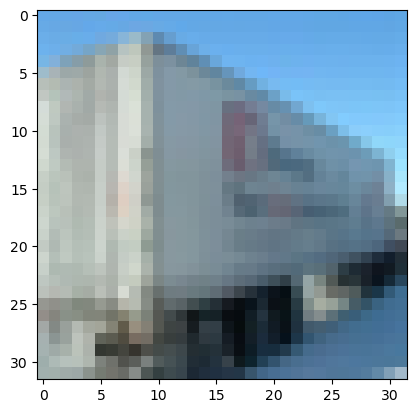

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(train_images[15])

We are just focusing on the training here, however, it would be a good idea to leave out some of the dataset for final testing to make sure that as we tune hyperparameters we are not including any knowledge we shouldn't be including.

Lets start by just training our previous model on this dataset.

In [28]:
model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(32, 32, 3)),
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Dense(140, activation='relu'),
        tf.keras.layers.Dense(10)
    ])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
history = model.fit(train_images, train_labels, 
                    validation_data=(test_images, test_labels), epochs=10)

Epoch 1/10
1563/1563 [==============================] - 7s 4ms/step - loss: 1.8993 - accuracy: 0.3105 - val_loss: 1.7787 - val_accuracy: 0.3601
Epoch 2/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.7604 - accuracy: 0.3708 - val_loss: 1.7059 - val_accuracy: 0.3905
Epoch 3/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.7187 - accuracy: 0.3855 - val_loss: 1.7056 - val_accuracy: 0.3947
Epoch 4/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.6907 - accuracy: 0.3963 - val_loss: 1.7096 - val_accuracy: 0.3869
Epoch 5/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.6792 - accuracy: 0.4020 - val_loss: 1.6673 - val_accuracy: 0.4071
Epoch 6/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.6649 - accuracy: 0.4066 - val_loss: 1.6591 - val_accuracy: 0.4117
Epoch 7/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.6557 - accuracy: 0.4066 - val_loss: 1.6356 - val_accuracy:

We see this model didn't do so well.  The reason is that this model does not have the requisite complexity to capture the details of this dataset.

On the other hand, this dataset is not super large, can we train a complex model?

Luckily we don't have to.  We can use a pre-trained model which is trained on large amounts of relatively similiar data, then simply train a small model on top to encode our particular problem.

The intuitive idea is that these large models are learning lots of fundamental features about images, we can use them as feature extractors.

Keras makes this quite easy, it comes with a bunch of pre-built 'applications' for things like image process as well as NLP.  We will use the `MobileNetV3Small` for demonstration purposes here.

First we need to create the model, notice the model is set as `trainable=False`, this is because we do not at this point want to train the weights of this model, only use them.

In [29]:
def get_base_model():
    base_model = tf.keras.applications.MobileNetV3Small(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False
    return base_model

Now we can create a function `get_model` which will create our overall model.  We will use an alternate way of create models in Keras, sometimes called the *functional* API.  It will make it a bit easier to use our pre-trained model.  Note the following

- We rescale the images, models often will have an expected feature input.
- We apply a `GlobalAveragePooling2D` layer.  This averages over the feature vector so we can then apply our final classification layers to it.

In [52]:
def get_model():
    base_model = get_base_model()
    inputs = tf.keras.Input(shape=(32, 32, 3))
    scale =  tf.keras.layers.Lambda(
        lambda image : tf.image.resize_with_pad(image, 224, 224)
    )(inputs)
    rescale = tf.keras.applications.mobilenet_v3.preprocess_input(scale)
    x = base_model(rescale, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(.3)(x)
    outputs = tf.keras.layers.Dense(10)(x)
    return tf.keras.Model(inputs, outputs)

In [53]:
get_model()

We will use a strategy here.  Typically we do not need to do this, however, if we want to make use of a TPU or GPU, this will make the code translate more easily.  

In [54]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = get_model()
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 lambda_2 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d_2   (None, 576)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_5 (Dropout)         (None, 576)               0         
                       

Note that this next cell will run really slowly if we only have CPU installed, so we will only run for a little bit, however, we can switch to a GPU or TPU with almost the same code and see a very large performance gain.

In [32]:
history = model.fit(
    train_images, 
    train_labels, 
    validation_data=(test_images, test_labels),
    epochs=1
)

1563/1563 [==============================] - 278s 172ms/step - loss: 0.6130 - accuracy: 0.7886 - val_loss: 0.4119 - val_accuracy: 0.8560


If we want to squeeze a bit more performance out, we can actually retrain part of the original network, however, we want to make sure we are not retraining from start. 

In [33]:
model.layers

In [34]:
base_model = model.layers[2]

In [35]:
base_model.trainable

False

We will make the base model trainable, but only the final few layers.

In [36]:
base_model.trainable = True
for layer in base_model.layers[:200]:
    layer.trainable = False

In [37]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=.00001),
              metrics=['accuracy'])

In [38]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 576)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 576)               0         
                                                                 
 dense_18 (Dense)            (None, 128)               73856 

Now we can continue training the model.

In [39]:
history_final = model.fit(
    train_images, 
    train_labels, 
    validation_data=(test_images, test_labels),
    initial_epoch=history.epoch[-1],
    epochs=2
)

Epoch 1/2
1563/1563 [==============================] - 352s 219ms/step - loss: 0.4385 - accuracy: 0.8488 - val_loss: 0.3558 - val_accuracy: 0.8794
Epoch 2/2
1563/1563 [==============================] - 341s 218ms/step - loss: 0.4019 - accuracy: 0.8614 - val_loss: 0.3411 - val_accuracy: 0.8822
